In [1]:
#  imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
from tqdm.notebook import tqdm
from collections import Counter
import seaborn as sns

# set up R and rpy2 funcitons for R interfacing

import os
os.environ['R_HOME'] = 'C:\Program Files\R\R-4.3.2'
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import rpy2.robjects as ro
from rpy2.rinterface import Sexp
from pandas.core.frame import DataFrame
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
from rpy2.robjects import numpy2ri

# Import extracted features and labels for predicting

In [28]:
# load features
X = pd.read_csv(os.getcwd() + r'\Features.csv', index_col='Unnamed: 0')
# load labels
y = pd.read_csv(os.getcwd() + r'\Labels.csv', index_col='Unnamed: 0').squeeze()
# check shape
X.shape, y.shape


((16, 69), (16,))

# Feature Selection and Predictions

## LASSO

### Explanatory model

In [29]:
# set up Lasso pipeine
pipe = Pipeline([
                    ('scaler',RobustScaler()),
                    ('model',Lasso(max_iter = 1000000))
])


# find best regularization term (alpha) for selecting features
search = GridSearchCV(pipe,
                      {'model__alpha':np.arange(0.01,500,5)},
                      cv = 14, verbose=0, return_train_score=True, scoring='neg_mean_squared_error')

# fit the gridsearch
search.fit(X,y)

# predict with the best fit estimator pipeline
# to show the fit of the training set
pred = search.predict(X)

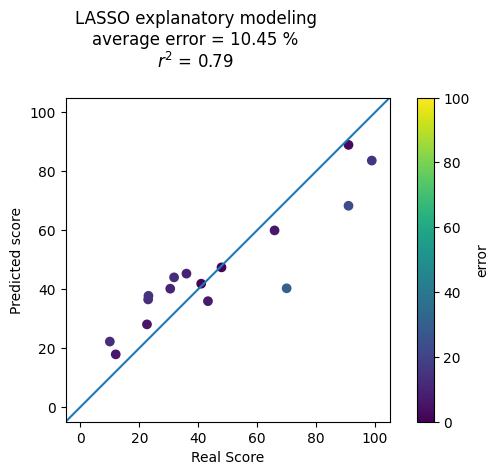

In [30]:
# plot training (exploratory) model fit
plt.scatter(x=y, y=pred, c=abs(pred-y))
plt.gca().axline([0,0], [100,100])
# get R2 score and average error
r2s = r2_score(y, pred)
averr = np.mean(abs(pred-y))
plt.suptitle(f'LASSO explanatory modeling\naverage error = {averr:.2f} %\n$r^2$ = {r2s:.2f}' )
plt.clim(0,100)
plt.colorbar(label='error')
plt.ylabel('Predicted score')
plt.xlabel('Real Score')
plt.tight_layout()
plt.gca().set_aspect(1)



### Predictive model 
<br>with leave one out validation

In [49]:
#  leave one out, find features then predict; for each

# set up results dataframe
new_preds = pd.Series(index = y.index, name='pred_score', dtype = 'float64')
new_diffs = pd.Series(index = y.index, name='difference', dtype = 'float64')

# set up list to append chosen feature names to
features_test = []

# set up df to save chosen feature weights (coefs)
coef_df = pd.DataFrame(columns=X.columns, index=range(len(y)), dtype=float)

# loop through squads to leave-them-out
for count, name in enumerate(tqdm(y.index)):
        
    # get all data but one squad
    X_train = X.drop(name, inplace=False)
    y_train = y.drop(name, inplace=False)

    # get the left out squad's data
    X_test = X.loc[name]
    y_test = y.loc[name]

    # set up Lasso pipeine
    pipe = Pipeline([
                        ('scaler',RobustScaler()),
                        ('model',Lasso(max_iter = 1000000))
    ])

    # find best regularization term (alpha) for selecting features 
    search = GridSearchCV(pipe,
                        {'model__alpha':np.arange(0.01,100,5)},
                        cv = 13, verbose=0, return_train_score=True, scoring='neg_mean_squared_error')

    # fit gridsearch
    search.fit(X_train.values,y_train)

    # make prediction from best fit estimator pipeline
    pred = search.predict(X_test.values.reshape(1, -1))

    # get non-zero coefficients and feature names
    coefficients_LOO = search.best_estimator_.named_steps['model'].coef_
    importance_LOO = np.abs(coefficients_LOO)
    best_features_LOO = np.array(X.columns)[importance_LOO > 0]

    # save chosen (non-zero coef) feature names
    
    features_test.append(best_features_LOO)
    # save coefficients of chosen features
    coef_df.loc[count, best_features_LOO] = coefficients_LOO[importance_LOO > 0]

    # add prediction to results list
    new_preds[name] = pred
    new_diffs[name] = abs(pred - y_test)

# print results list
RealAndPred = pd.concat([y, new_preds, new_diffs], axis=1)
print(RealAndPred)

  0%|          | 0/16 [00:00<?, ?it/s]

         score  pred_score  difference
PLT1SQ1   41.0   69.872457   28.872457
PLT1SQ2   12.0   18.654809    6.654809
PLT1SQ3   70.0   29.118277   40.881723
PLT2SQ1   36.0   63.698886   27.698886
PLT2SQ2   91.0   49.747087   41.252913
PLT3SQ1   23.0   42.216688   19.216688
PLT3SQ2   10.0   33.979071   23.979071
PLT3SQ3   91.0  100.501131    9.501131
PLT4SQ1   65.9   48.414279   17.485721
PLT4SQ2   47.9   46.741699    1.158301
PLT4SQ3   43.3   35.588963    7.711037
PLT5SQ1   98.9   68.658329   30.241671
PLT5SQ2   31.8   51.002225   19.202225
PLT5SQ3   22.6    6.419078   16.180922
PLT6SQ2   23.1   46.555013   23.455013
PLT6SQ3   30.5   38.832894    8.332894


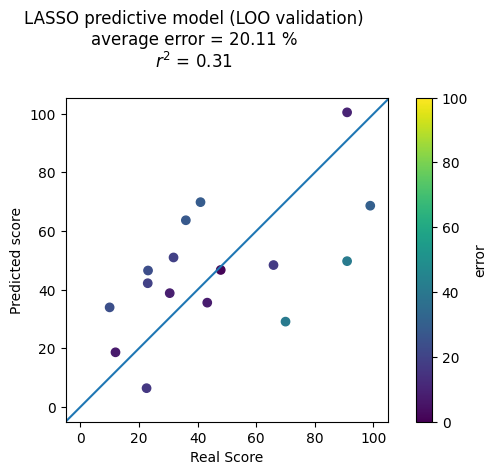

In [50]:
plt.scatter(x=RealAndPred.score, y=RealAndPred.pred_score, c=RealAndPred.difference)
plt.gca().axline([0,0], [100,100])
r2s = r2_score(RealAndPred.score, RealAndPred.pred_score)
averr = RealAndPred.difference.abs().mean()
plt.suptitle(f'LASSO predictive model (LOO validation)\naverage error = {averr:.2f} %\n$r^2$ = {r2s:.2f}' )
plt.clim(0,100)
plt.colorbar(label='error')
plt.ylabel('Predicted score')
plt.xlabel('Real Score')
plt.tight_layout()
plt.gca().set_aspect(1)

#### Plot selected features from LOO iterations for 'stability' comparison

Text(0.5, 0.98, 'Feature weights for LASSO leave-one-out iterations')

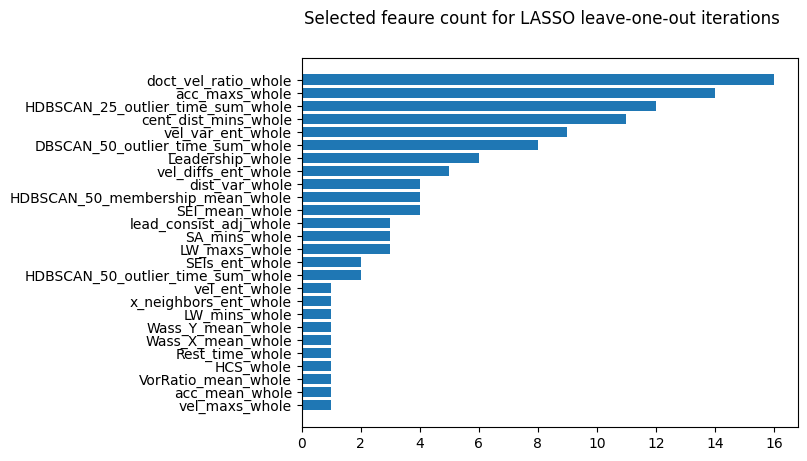

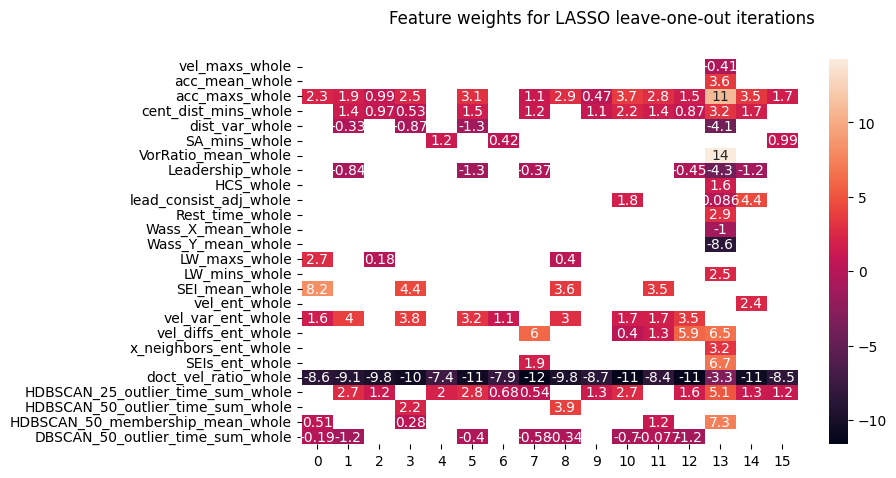

In [51]:
# get a count for how many times each feature appear
ftest=[]
for f in features_test:
    for t in f: 
        ftest.append(t)
counts = Counter(ftest)
sorted_counts = dict(sorted(counts.items(), key=lambda x:x[1]))

# plot the feature counts as a bar graph
fName, fCount = zip(*sorted_counts.items())   
plt.barh(fName, fCount) 
plt.suptitle('Selected feaure count for LASSO leave-one-out iterations')

# plot heatmap of feature coefficients
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(coef_df[coef_df.columns[coef_df.any()]].T, annot=True,)
plt.suptitle('Feature weights for LASSO leave-one-out iterations')


## T-Rex selector

Set up R-wrapper funciton

In [52]:
# add Trex function
r = robjects.r
r["source"]("R\TRexSelector\Trex.R")

# set up trex function
run_trex_r = robjects.globalenv["run_Trex"]

# make Trex python-R function
def run_Trex(
    X: np.ndarray, y: np.ndarray#, FDR: float = 0.348
) -> DataFrame:
    
    """
    Arguments:
        FDR: target false detection rate
    """

    # combine X an y for scaling and passing to R
    df_X_and_y = pd.DataFrame(X)
    df_X_and_y["y"] = pd.Series(y)

    # normalize data
    df_X_and_y = df_X_and_y.apply(zscore)

    # convert pd df to R df
    with localconverter(ro.default_converter + pandas2ri.converter):
        df_r = ro.conversion.py2rpy(df_X_and_y)
    
    # # convert np variable to R variable
    # with localconverter(ro.default_converter + numpy2ri.converter):
    #     tau_r = ro.conversion.py2rpy(tau)

    # run the R 
    df_result_r = run_trex_r(df_r)#, tau_r, n_iter)

    # convert the result back to np variable
    with localconverter(ro.default_converter + pandas2ri.converter):
        np_result = ro.conversion.rpy2py(df_result_r)

    return np_result

### Explanatory model

In [53]:
# run TRex for feature selection
results = run_Trex(X.values, y.values)

# make T-Rex selection output (from boolean) a list of features
selected_feats = list(X.columns[results.astype('bool')])

# print feature names and number of features
print(str(len(selected_feats)) + ' features selected')
print(selected_feats)

# run a regression based of chosen features
pipe = Pipeline([
                     ('scaler',RobustScaler()),
                     ('model', LinearRegression())
    ])

# fit the regression pipeline
pipe.fit(X[selected_feats], y)

# predict to show the fit of the training set
pred = pipe.predict(X[selected_feats])

4 features selected
['vel_var_whole', 'VAR_mean_whole', 'vel_diffs_ent_whole', 'doct_vel_ratio_whole']


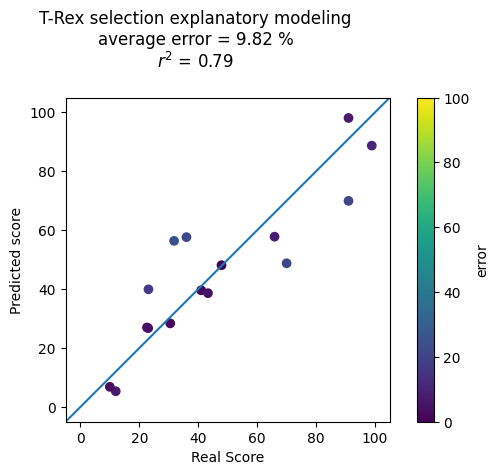

In [54]:
# plot results from explanatory model
plt.scatter(x=y, y=pred, c=abs(pred-y))
plt.gca().axline([0,0], [100,100])
# get Rsq score and average error
r2s = r2_score(y, pred)
averr = np.mean(abs(pred-y))
plt.suptitle(f'T-Rex selection explanatory modeling\naverage error = {averr:.2f} %\n$r^2$ = {r2s:.2f}' )
plt.clim(0,100)
plt.colorbar(label='error')
plt.ylabel('Predicted score')
plt.xlabel('Real Score')
plt.tight_layout()
plt.gca().set_aspect(1)



### Predictive model 
<br>with leave one out validation

In [55]:
#  leave one out, find features then predict for each

# set up results dataframe
new_preds = pd.Series(index = y.index, name='pred_score', dtype = 'float64')
new_diffs = pd.Series(index = y.index, name='difference', dtype = 'float64')

# set up list to append chosen feature names to
features_test = []

# set up df to save chosen feature weights (coefs)
coef_df = pd.DataFrame(columns=X.columns, index=range(len(y)), dtype=float)

# loop through squads to leave-them-out
for count, name in enumerate(tqdm(y.index)):
        
    # get all data but one squad
    X_train = X.drop(name, inplace=False)
    y_train = y.drop(name, inplace=False)

    # get the left out squad's data
    X_test = X.loc[name]
    y_test = y.loc[name]

    # run TRex for feature selection
    results = run_Trex(X.values, y.values)

    # make T-Rex selection output (from boolean) a list of features
    selected_feats = list(X.columns[results.astype('bool')])

    # # print feature names and number of features
    # print(str(len(selected_feats)) + ' features selected')
    # print(selected_feats)

    # run a regression based of those feats
    pipe = Pipeline([
                        ('scaler',RobustScaler()),
                        ('model', LinearRegression())
        ])

    # fit the regression pipeline
    pipe.fit(X_train[selected_feats].values, y_train)

    # make predictions
    pred = pipe.predict(X_test[selected_feats].values.reshape(1, -1))

    # append chosen feature names and their associated regression weights 
    features_test.append(selected_feats)
    coef_df.loc[count, selected_feats] = pipe.named_steps.model.coef_

    # add prediction to results list
    new_preds[name] = pred
    new_diffs[name] = abs(pred - y_test)

# print results list
RealAndPred = pd.concat([y, new_preds, new_diffs], axis=1)
print(RealAndPred)

  0%|          | 0/16 [00:00<?, ?it/s]

         score  pred_score  difference
PLT1SQ1   41.0   38.714834    2.285166
PLT1SQ2   12.0   -2.615535   14.615535
PLT1SQ3   70.0   38.620389   31.379611
PLT2SQ1   36.0   58.924483   22.924483
PLT2SQ2   91.0   65.178602   25.821398
PLT3SQ1   23.0   28.414102    5.414102
PLT3SQ2   10.0    4.936450    5.063550
PLT3SQ3   91.0  121.105566   30.105566
PLT4SQ1   65.9   67.490808    1.590808
PLT4SQ2   47.9   48.210736    0.310736
PLT4SQ3   43.3   37.880796    5.419204
PLT5SQ1   98.9   87.395662   11.504338
PLT5SQ2   31.8   61.803831   30.003831
PLT5SQ3   22.6   37.137806   14.537806
PLT6SQ2   23.1   38.664216   15.564216
PLT6SQ3   30.5   27.360603    3.139397


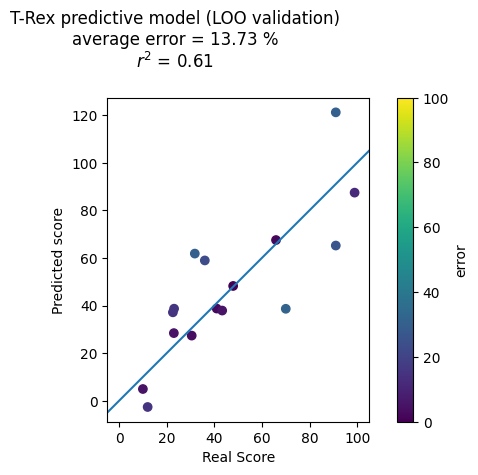

In [56]:
# plot results of predictive model
plt.scatter(x=RealAndPred.score, y=RealAndPred.pred_score, c=RealAndPred.difference)
plt.gca().axline([0,0], [100,100])
# get Rsq score and average error
r2s = r2_score(RealAndPred.score, RealAndPred.pred_score)
averr = RealAndPred.difference.abs().mean()
plt.suptitle(f'T-Rex predictive model (LOO validation)\naverage error = {averr:.2f} %\n$r^2$ = {r2s:.2f}' )
plt.clim(0,100)
plt.colorbar(label='error')
plt.ylabel('Predicted score')
plt.xlabel('Real Score')
plt.tight_layout()
plt.gca().set_aspect(1)

#### Plot selected features from LOO iterations for 'stability' comparison

Text(0.5, 0.98, 'Feature weights for T-Rex leave-one-out iterations')

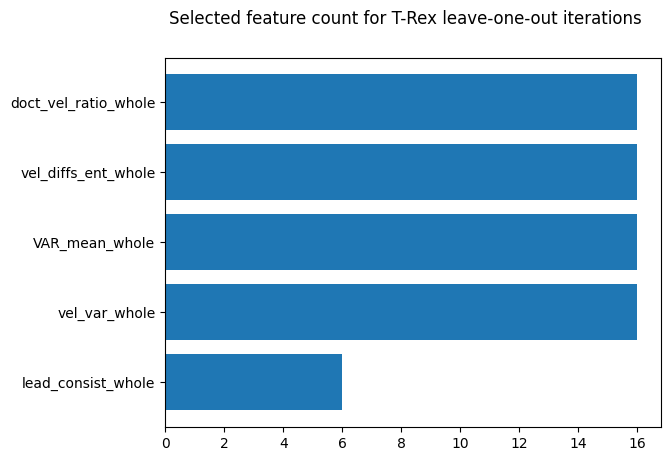

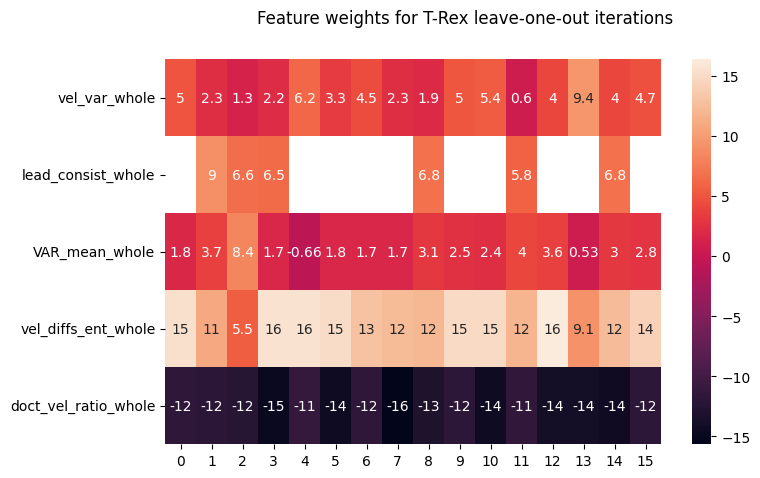

In [57]:
# get a count for how many times each feature appear
ftest=[]
for f in features_test:
    for t in f: 
        ftest.append(t)
counts = Counter(ftest)
sorted_counts = dict(sorted(counts.items(), key=lambda x:x[1]))

# plot the feature counts as a bar graph
fName, fCount = zip(*sorted_counts.items())   
plt.barh(fName, fCount) 
plt.suptitle('Selected feature count for T-Rex leave-one-out iterations')

# plot heatmap of feature coefficients
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(coef_df[coef_df.columns[coef_df.any()]].T, annot=True,)
plt.suptitle('Feature weights for T-Rex leave-one-out iterations')
